# Depth Model - Data Visualization

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/My\ Drive/DepthProject

[Errno 2] No such file or directory: 'gdrive/My Drive/DepthProject'
/content


In [29]:
ls -l

total 8404999
-rw------- 1 root root     283759 Feb 26  2019  0_1551071122749_Poster.pptx
-rw------- 1 root root        151 Nov 13  2018  1.gdoc
-rw------- 1 root root      19951 May 19  2018  1MV15CS099.jpg
-rw------- 1 root root      60246 May 19  2018  1MV15CS099.pdf
-rw------- 1 root root        151 Sep 24  2018  1_unit_15x15_0_goldenFmt.gdoc
-rw------- 1 root root        151 May 31  2018 '3d snakegane code (1).gdoc'
-rw------- 1 root root      16799 May 31  2018 '3d snakegane code.docx'
-rw------- 1 root root        151 May 31  2018 '3d snakegane code.gdoc'
-rw------- 1 root root        151 Nov 14  2018  3.html.txt.gdoc
-rw------- 1 root root        151 Dec  8  2017 '5th sem exam schedule.gdoc'
-rw------- 1 root root        151 Apr  1  2019  ABSTRACT.gdoc
-rw------- 1 root root      17648 Apr 24  2019  ACKNOWLEDGEMENT.odt
-rw------- 1 root root     109310 Mar 14  2016 'Admit Card (1).pdf'
-rw------- 1 root root     109310 Mar 14  2016 'Admit Card.pdf'
drwx------ 2 root root       

In [0]:
from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from PIL import Image
import torchvision.transforms as T
import os
import torch
sns.set()

# Create the Dataset

In [31]:
%cd /content/gdrive/My\ Drive

/content/gdrive/My Drive


In [32]:
!ls -la | grep "fg"

-rw------- 1 root root 2289574765 May 10 10:01 dataset_fg_bg_final
-rw------- 1 root root  716783927 May 10 10:01 dataset_fg_bg_Mask_final
-r-------- 1 root root 1797599043 May 10 12:20 depth_fg_bg (1).zip
-rw------- 1 root root 1480413706 May 10 08:45 depth_fg_bg (2).zip
-r-------- 1 root root 1797599043 May 10 12:20 depth_fg_bg.zip
-rw------- 1 root root   49990342 May 10 12:16 fg.zip


In [0]:
class DenseDepth(Dataset):
    '''
    DenseDepth Dataset

    Input is fg_bg image AND bg image
    Target is fg_bg_mask AND depth_fg_bg image
    '''
    def __init__(self, root, data='fg_bg', train=True, transform=None, target_transform=None, download=False):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        self.data = data


        if self.data == 'fg_bg':
            fg_bg_zip =  ZipFile(os.path.join(self.root,'dataset_fg_bg_final'), 'r') # fg_bg
            fg_bg_paths = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_bg_zip
            self.image_paths = fg_bg_paths
        elif self.data == 'bg':
            bg_zip = ZipFile(os.path.join(self.root,'bg.zip'), 'r') # bg
            bg_paths = [info.filename for info in bg_zip.infolist() if not info.is_dir()]
            self.image_zip = bg_zip
            self.image_paths = bg_paths
        elif self.data == 'fg':
            fg_zip = ZipFile(os.path.join(self.root,'fg.zip'), 'r') # fg
            fg_paths = [info.filename for info in fg_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_zip
            self.image_paths = fg_paths
        elif self.data == 'fg_bg_mask':
            fg_bg_mask_zip = ZipFile(os.path.join(self.root,'dataset_fg_bg_Mask_final'), 'r') # fg_bg_mask
            fg_bg_mask_paths = [info.filename for info in fg_bg_mask_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_bg_mask_zip
            self.image_paths = fg_bg_mask_paths
        elif self.data == 'depth_fg_bg':
            depth_fg_bg_zip =  ZipFile(os.path.join(self.root,'depth_fg_bg.zip'), 'r') # target
            depth_fg_bg_paths = [info.filename for info in depth_fg_bg_zip.infolist() if not info.is_dir()]
            self.image_zip = depth_fg_bg_zip
            self.image_paths = depth_fg_bg_paths
        else:
            raise f'{data} is not a valid option'


    def __getitem__(self, index):
        imgdata = self.image_zip.read(self.image_paths[index])
        img = Image.open(io.BytesIO(imgdata))

        if self.data == 'depth_fg_bg':
            img = img.convert('L')
        elif self.data == 'fg':
            width, height = img.size

            bigside = width if width > height else height

            background = Image.new('RGBA', (bigside, bigside), (255, 0, 0, 0))
            offset = (int(round(((bigside - width) / 2), 0)), int(round(((bigside - height) / 2),0)))

            background.paste(img, offset)
            img = background
            img = img.resize((200, 200), Image.ANTIALIAS)
        else:
            img = img.convert("RGB")

        img = np.array(img)

        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return len(self.image_paths)

In [0]:
def plot_images_horizontally(images):
    fig = plt.figure(figsize=(50, 40))
    num_imgs = images.shape[0]
    for i in range(num_imgs):
        fig.add_subplot(1, num_imgs, i + 1)

        # render image tensor
        img = images[i]
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))

        plt.imshow(npimg)
        plt.axis('off')

# Foreground Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [19]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 4, 200, 200])

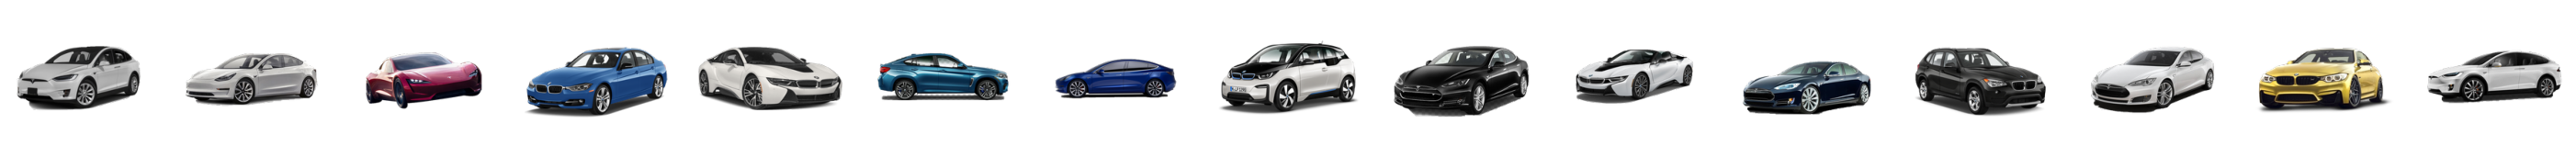

In [20]:
plot_images_horizontally(images)

# Background Images

In [0]:
bg_dataset = DenseDepth(root='./', data='bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [15]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 4, 200, 200])

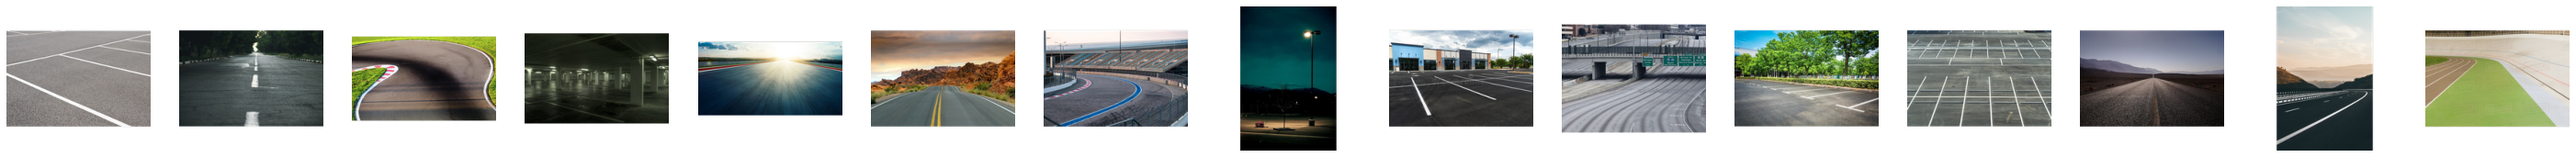

In [16]:
plot_images_horizontally(images)

# Foreground Background Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg_bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [22]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 4, 200, 200])

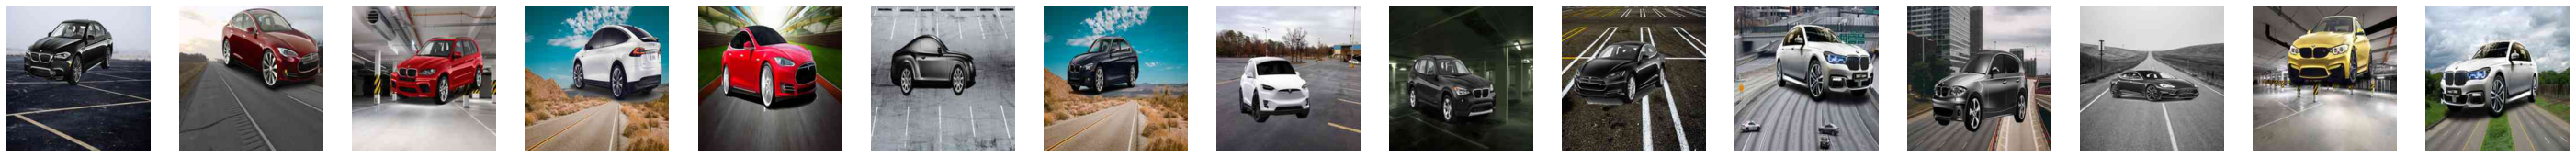

In [23]:
plot_images_horizontally(images)

# Foreground Background Mask Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg_bg_mask', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [26]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 4, 200, 200])

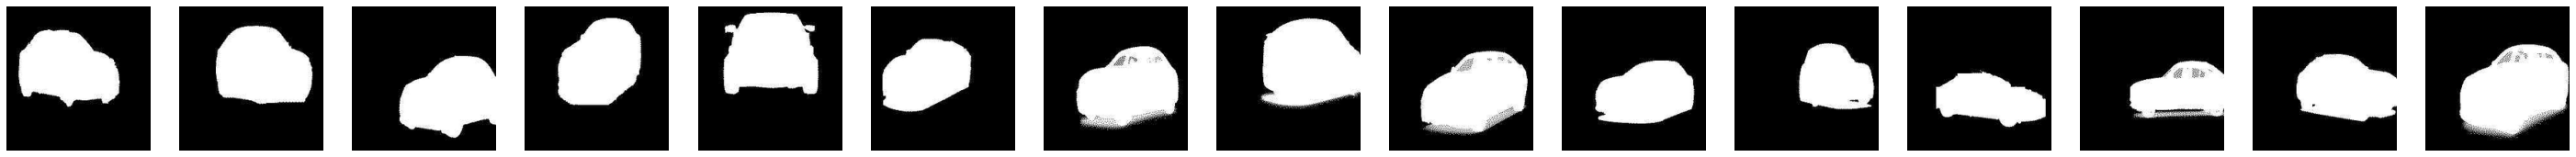

In [27]:
plot_images_horizontally(images)

# Foreground Backgroud Depth Images

In [0]:
bg_dataset = DenseDepth(root='./', data='depth_fg_bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [40]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 1, 200, 200])

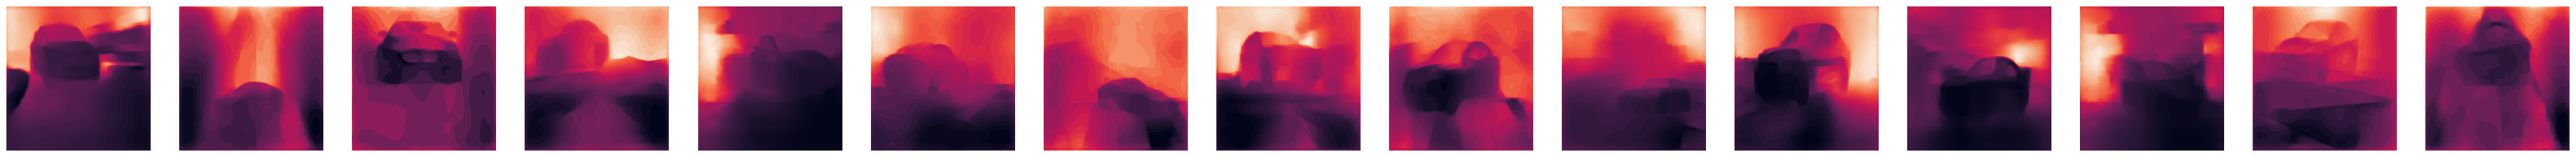

In [41]:
fig = plt.figure(figsize=(50, 40))
num_imgs = images.shape[0]
for i in range(num_imgs):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    img = images[i][0]
    npimg = img.numpy()
    
    plt.imshow(npimg)
    plt.axis('off')